# EDA com Pandas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
import ast

## Carregamento dos Datasets

In [3]:
# Carregar o dataset
df = pd.read_csv("tmdb_5000_movies.csv")

# Verificar o número de linhas e colunas
print("Número de linhas e colunas:", df.shape , "\n")



Número de linhas e colunas: (4803, 20) 



Algumas informações


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [5]:
df.describe()


,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


Verificar Valores Unicos

In [6]:
print("\n=== Valores Únicos (nunique) ===")

df.nunique()



=== Valores Únicos (nunique) ===


budget                   436
genres                  1175
homepage                1691
id                      4803
keywords                4222
original_language         37
original_title          4801
overview                4800
popularity              4802
production_companies    3697
production_countries     469
release_date            3280
revenue                 3297
runtime                  156
spoken_languages         544
status                     3
tagline                 3944
title                   4800
vote_average              71
vote_count              1609
dtype: int64

Verificar se há Duplicatas

In [7]:
print("\n=== Duplicatas (linhas) ===")
df[df.duplicated()]



=== Duplicatas (linhas) ===


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count


Verificar Valores nulos

In [8]:
print("\n=== Nulos por coluna ===")
df.isna().sum()



=== Nulos por coluna ===


budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64

In [9]:
# Selecionar colunas essenciais para análise/merge
tmdb = df[['id','original_title','release_date','genres','vote_average','vote_count']].copy()
tmdb = tmdb.rename(columns={'id':'tmdbId'})

In [13]:
# precisamos converter essas colunas em tipos de dados adequados
tmdb['release_year'] = pd.to_datetime(tmdb['release_date'], errors='coerce').dt.year
df['release_year'] = df['release_date'].dt.year


### Carregamento dos Datasets MovieLens

In [14]:
links = pd.read_csv("links.csv")
movies_ml = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")

print("Formato links:", links.shape)
print("Formato movies:", movies_ml.shape)
print("Formato ratings:", ratings.shape)


Formato links: (87585, 3)
Formato movies: (87585, 3)
Formato ratings: (32000204, 4)


In [15]:
# garantir tipos e chaves
links['tmdbId'] = pd.to_numeric(links['tmdbId'], errors='coerce').astype('Int64')
links = links.dropna(subset=['tmdbId']).copy()
links['tmdbId'] = links['tmdbId'].astype('int64')
ratings['movieId'] = ratings['movieId'].astype('int64')

#### Carregamento DataSet Oscar

In [16]:
oscars = pd.read_csv("the_oscar_award.csv")
oscars.head()


,year_film,year_ceremony,ceremony,category,canon_category,name,film,winner
0,1927,1928,1,ACTOR,ACTOR IN A LEADING ROLE,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,ACTOR IN A LEADING ROLE,Richard Barthelmess,The Patent Leather Kid,False
2,1927,1928,1,ACTOR,ACTOR IN A LEADING ROLE,Emil Jannings,The Last Command,True
3,1927,1928,1,ACTOR,ACTOR IN A LEADING ROLE,Emil Jannings,The Way of All Flesh,True
4,1927,1928,1,ACTRESS,ACTRESS IN A LEADING ROLE,Louise Dresser,A Ship Comes In,False


#### Criação de uma nova tabela "Premiado"

In [17]:
# Criar coluna premiado: 1 se ganhou, 0 se não
oscars['premiado'] = oscars['winner'].astype(int)

Deixar só uma linha por filme

O dataset de Oscars tem várias linhas por filme (uma para cada categoria).
Vamos deixar um único registro por filme, com a informação de se já ganhou ou foi indicado.

In [18]:
# Considerar premiado se ganhou em qualquer categoria
oscars_grouped = oscars.groupby(['film', 'year_film']).agg(
    premiado=('premiado', 'max'),   # 1 se ganhou pelo menos 1 categoria
    indicado=('winner', 'count')    # número de indicações
).reset_index()

oscars_grouped.head(20)



,film,year_film,premiado,indicado
0,"$1,000 a Minute",1935,0,1
1,'38',1986,0,1
2,'Crocodile' Dundee,1986,0,1
3,'Round Midnight,1986,1,2
4,(A) Torzija [(A) Torsion],2003,0,1
5,...And Justice for All,1979,0,2
6,10,1979,0,2
7,102 Dalmatians,2000,0,1
8,12,2007,0,1
9,12 Angry Men,1957,0,3


In [22]:
# Normalizar títulos
oscars_grouped['title_norm'] = oscars_grouped['film'].str.lower().str.strip()

In [24]:
# Normalizar títulos no DataFrame tmdb
tmdb['title_norm'] = tmdb['original_title'].str.lower().str.strip()

# =======================================
# 5. Merge TMDB + Oscars
# =======================================
tmdb_oscars = pd.merge(
    tmdb, 
    oscars_grouped, 
    left_on=['title_norm','release_year'], 
    right_on=['title_norm','year_film'],
    how='left'
)

In [25]:
# Substituir NaN por 0
tmdb_oscars['premiado'] = tmdb_oscars['premiado'].fillna(0).astype(int)
tmdb_oscars['indicado'] = tmdb_oscars['indicado'].fillna(0).astype(int)


In [26]:
print("Merge TMDB + Oscars:", tmdb_oscars.shape)

Merge TMDB + Oscars: (4803, 12)


In [27]:
# =======================================
# 6. Conectar com MovieLens (links.csv)
# =======================================
tmdb_links = pd.merge(
    tmdb_oscars, 
    links[['movieId','tmdbId']], 
    on='tmdbId', 
    how='inner'
)

print("Merge TMDB+Oscars com Links:", tmdb_links.shape)


Merge TMDB+Oscars com Links: (4637, 13)


In [28]:
# =======================================
# 7. Juntar com Ratings
# =======================================
df_full = pd.merge(
    ratings, 
    tmdb_links, 
    on='movieId', 
    how='inner'
)

print("Dataset final:", df_full.shape)
print(df_full.head())

Dataset final: (21751729, 16)
   userId  movieId  rating  timestamp  tmdbId         original_title  \
0       1       17     4.0  944249077    4584  Sense and Sensibility   
1       1       25     1.0  944250228     451      Leaving Las Vegas   
2       1       34     2.0  943228491    9598                   Babe   
3       1       36     1.0  944249008     687       Dead Man Walking   
4       1      110     3.0  943231119     197             Braveheart   

  release_date                                             genres  \
0   1995-12-13  [{"id": 18, "name": "Drama"}, {"id": 10749, "n...   
1   1995-10-27  [{"id": 18, "name": "Drama"}, {"id": 10749, "n...   
2   1995-07-18  [{"id": 14, "name": "Fantasy"}, {"id": 18, "na...   
3   1995-12-29                      [{"id": 18, "name": "Drama"}]   
4   1995-05-24  [{"id": 28, "name": "Action"}, {"id": 18, "nam...   

   vote_average  vote_count  release_year             title_norm  \
0           7.2         352        1995.0  sense and s

In [29]:
# =======================================
# 8. EDA - Estatísticas básicas
# =======================================

print("\nDistribuição de premiados vs não premiados:")
print(df_full['premiado'].value_counts())


Distribuição de premiados vs não premiados:
premiado
0    15820596
1     5931133
Name: count, dtype: int64


In [30]:
print("\nMédia das notas por grupo:")
print(df_full.groupby('premiado')['rating'].mean())


Média das notas por grupo:
premiado
0    3.460640
1    3.864038
Name: rating, dtype: float64


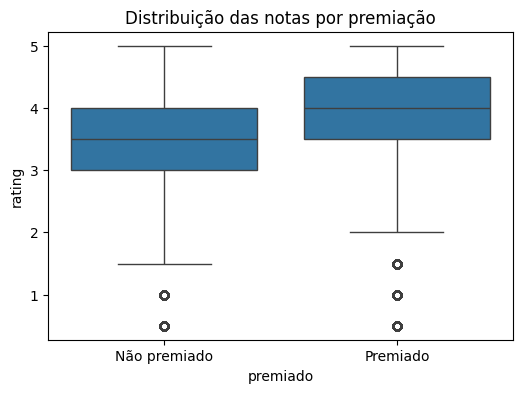

In [31]:
# Boxplot
plt.figure(figsize=(6,4))
sns.boxplot(x='premiado', y='rating', data=df_full)
plt.xticks([0,1], ['Não premiado','Premiado'])
plt.title("Distribuição das notas por premiação")
plt.show()

### Teste Estatístico

In [32]:
premiados = df_full[df_full['premiado']==1]['rating']
nao_premiados = df_full[df_full['premiado']==0]['rating']

##### Teste de normalidade (Shapiro)


In [42]:
# Teste de normalidade (Shapiro)
print("\nShapiro premiados:", shapiro(premiados.sample(5000, random_state=42)))
print("Shapiro não premiados:", shapiro(nao_premiados.sample(5000, random_state=42)))


Shapiro premiados: ShapiroResult(statistic=np.float64(0.8933996330797318), pvalue=np.float64(2.720765574781049e-50))
Shapiro não premiados: ShapiroResult(statistic=np.float64(0.9369785895119527), pvalue=np.float64(9.286056726816578e-42))


##### Teste t

In [33]:
# Teste t
t_stat, p_val = ttest_ind(premiados, nao_premiados, equal_var=False)
print("\nTeste t de Student:")
print("t =", t_stat, " | p-valor =", p_val)


Teste t de Student:
t = 847.1423716972663  | p-valor = 0.0


##### Mann-Whitney


In [34]:
# Mann-Whitney
u_stat, p_val_u = mannwhitneyu(premiados, nao_premiados, alternative='two-sided')
print("\nTeste Mann-Whitney U:")
print("U =", u_stat, " | p-valor =", p_val_u)



Teste Mann-Whitney U:
U = 57558360662192.5  | p-valor = 0.0
